<a href="https://colab.research.google.com/github/SEIGO55/ADS_deepL/blob/main/4_transfer_learning_vgg16_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目的
* **転移学習**でネコとイヌを高精度で分類する。

準備
* GPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# サブフォルダー
sub_folders = ['can', 'bin', 'petbottle', 'tabacco']

# 各サブフォルダー内の画像ファイル数を数える
t0 = t1 = t2 = t3 = 0

for index, folder in enumerate(sub_folders):
    full_path = os.path.join('/content/drive/MyDrive/Deep learning/project/3data/train/', folder)
    count = len([file for file in os.listdir(full_path) if file.endswith(('.jpg', '.jpeg', '.png'))])

    if folder == 'can':
        t0 = count
    elif folder == 'bin':
        t1 = count
    elif folder == 'petbottle':
        t2 = count
    elif folder == 'tabacco':
        t3 = count

ttl_train = t0 + t1 + t2 + t3

# 各変数に格納されたファイル数を出力
print("train:","can:", t0, "bin:", t1, "petbottle:", t2, "tabacco:", t3, "total", t0+t1+t2+t3)

# 各サブフォルダー内の画像ファイル数を数える
v0 = v1 = v2 = v3 = 0

for index, folder in enumerate(sub_folders):
    full_path = os.path.join('/content/drive/MyDrive/Deep learning/project/3data/validation/', folder)
    count = len([file for file in os.listdir(full_path) if file.endswith(('.jpg', '.jpeg', 'JPG','.png'))])

    if folder == 'can':
        v0 = count
    elif folder == 'bin':
        v1 = count
    elif folder == 'petbottle':
        v2 = count
    elif folder == 'tabacco':
        v3 = count

ttl_validation = v0 + v1 + v2 + v3

# 各変数に格納されたファイル数を出力
print("validation:","can:", v0, "bin:", v1, "petbottle:", v2, "tabacco:", v3, "total", v0+v1+v2+v3)

train: can: 213 bin: 120 petbottle: 130 tabacco: 174 total 637
validation: can: 84 bin: 50 petbottle: 166 tabacco: 50 total 350


VGG16を利用した転移学習のためのプログラムを作成

プログラムの構造
* 訓練データを**FC層を取り除いた**VGG16モデルに入力し、出力結果をバリナリデータとして保存
* これを再度読み込んで、**自前のFC層を備えたネットワーク**で学習
* 最終的に1個のニューロンに出力
* テストデータについても同じ処理

if not os.path.exists
* outputというディレクトリの存在チェックを行いなければ作成

if not os.path.exists('output'):

    os.mkdir('output')

* Pythonで新しいディレクトリ（フォルダ）を作成するには標準ライブラリosモジュールのos.mkdir()を使います。

VGG16: https://keras.io/ja/applications/
* ImageNetで学習した重みをもつ画像分類のモデル

.flow_from_directory: https://keras.io/ja/preprocessing/image/
* ディレクトリへのパスを受け取り、拡張/正規化したデータのバッチを生成します。

.predict_generator: https://keras.io/ja/models/sequential/

* ジェネレータから生成されたデータに対して予測します。

npyファイル: https://note.nkmk.me/python-numpy-load-save-savez-npy-npz/
* NumPy配列ndarrayをNumPy独自フォーマットのバイナリファイル（npy, npz）で保存する場合、データ型dtypeや形状shapeなどの情報がそのまま保存される。

npyファイル: https://qiita.com/ShozF/items/ef3629064f930e85c20f
* ヘッダ部の情報に基づいて、配列要素がバイト列として隙間なく格納されています。

os.path.join()
* 引数に渡した2つの文字列を結合し、1つのパスにすることが出来ます。

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
import numpy as np
import os

#画像の変更
#num_train = 2000              # 訓練データの画像数
num_train = ttl_train

#num_validation = 800          # テストデータの画像数
num_validation = ttl_validation

img_h, img_w = 150, 150       # 画像のサイズ
channels = 3                  # チャンネル数
batch_size = 32               # ミニバッチのサイズ

#変更する
train_data_dir = '/content/drive/MyDrive/Deep learning/project/3data/train' # 訓練データのフォルダ
validation_data_dir = '/content/drive/MyDrive/Deep learning/project/3data/validation' # テストデータのフォルダ
result_dir = '/content/drive/MyDrive/Deep learning/project/3data/results'        # VGG16の出力結果を保存するフォルダ

# resultsフォルダが存在しなければ作成
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

def save_VGG16_outputs():
    '''
    VGG16にDog vs Catの訓練データ、テストデータを入力し、
    出力結果をnpyファイルに保存する

　　'''
    # VGG16モデルと学習済み重みを読み込む
    model = VGG16(
        include_top=False,            # 全結合層は層（FC）は読み込まない
        weights='imagenet',           # ImageNetで学習した重みを利用
        input_shape=(img_h, img_w, channels) # 入力データの形状
    )
    # サマリを表示
    model.summary()

    # データを読み込むジェネレータを生成
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    # Dog vs Catの訓練データを生成するジェネレータ
    train_generator = datagen.flow_from_directory(
        train_data_dir,               # 訓練データのフォルダ
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # 訓練データの正解ラベルを出力
    print('train-label:',train_generator.class_indices)
    # 訓練データをVGG16モデルに入力し、その出力をファイルに保存
    vgg16_train = model.predict_generator(
        train_generator,              # ジェネレータ
        verbose=1                     # 進捗状況を出力
    )
    # 訓練データの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_train.npy'),
            vgg16_train)

    # Dog vs Catのテストデータを生成するジェネレータ
    validation_generator = datagen.flow_from_directory(
        validation_data_dir,          # 訓練データのフォルダ
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # テストデータの正解ラベルを出力
    print('test-label:',validation_generator.class_indices) #class_indicesでラベルと番号を取得
    # テストデータをVGG16モデルに入力する
    vgg16_test = model.predict_generator(
        validation_generator,         # ジェネレータ
        verbose=1                     # 進捗状況を出力
    )
    # テストデータの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_test.npy'),
            vgg16_test)

VGG16に入力して結果を保存

In [ ]:
# VGG16に入力して結果を保存
save_VGG16_outputs()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

<ipython-input-3-32f0dc9d056f>:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg16_train = model.predict_generator(


20/20 [==============================] - 302s 16s/step
Found 350 images belonging to 4 classes.
test-label: {'bin': 0, 'can': 1, 'petbottle': 2, 'tabacco': 3}


<ipython-input-3-32f0dc9d056f>:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg16_test = model.predict_generator(


11/11 [==============================] - 59s 6s/step


VGG16の出力をFCネットワークで学習
* 独自のFC層を構築
* VGG16の出力から学習

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense

def train_FClayer():
    '''
    VGG16の出力を入力し、FCネットワークで学習する

    '''
    # 訓練データのVGG16からの出力を読み込む
    train_data = np.load(
        os.path.join(result_dir, 'vgg16_train.npy'))
    # VGG16の訓練データの形状を出力
    print(train_data.shape)
    # 正解ラベルの作成 最初の300枚が0(can)、次の300枚が1(bin)、次の300枚が1(petbottle)、次の300枚が1(petbottle)
    #次の300枚が1(tabaco)、次の300枚が1(others)
    #train_labels = np.array(
        #[0] * int(num_train / 4) + [1] * int(num_train / 4)+ [2] * int(num_train / 4)+ [3] * int(num_train / 4)
    #)
    train_labels = np.array(
        [0] * t0 + [1] * t1+ [2] * t2+ [3] * t3
    )


    # テストデータのVGG16からの出力を読み込む
    validation_data = np.load(
        os.path.join(result_dir, 'vgg16_test.npy'))
    # VGG16のテストデータの形状を出力
    print(validation_data.shape)
    # 正解ラベルを作成
    # ネコが0、イヌが1
    # 最初の400枚(cat)に0次の400枚(dog)に1を割り当てる
    #最初の90枚が0(can)、次の90枚が1(bin)、次の90枚が1(petbottle)、次の90枚が1(petbottle)
    #次の90枚が1(tabaco)、次の90枚が1(others)
    #validation_labels = np.array(
        #[0] * int(num_validation / 4) + [1] * int(num_validation / 4) + [2] * int(num_validation / 4) + [3] * int(num_validation / 4)
    #)

    validation_labels = np.array(
        [0] * v0 + [1] *v1 + [2] *v2 + [3] * v3
    )

    # FCネットワークの作成
    model = Sequential()
    # Flatten　全結合層への入力を4階テンソルから2階テンソルに変換する
    model.add(Flatten(input_shape=train_data.shape[1:]))
    # 全結合層
    model.add(Dense(256,                   # ニューロン数は256
                    activation='relu'))    # 活性化関数はReLU
    model.add(Dropout(0.5))                # ドロップアウト50％
    # 出力層
    model.add(Dense(4,                     # ニューロン数は5
                    activation='softmax')) # 活性化関数はReLU

    # モデルのコンパイル
    model.compile(
        loss='sparse_categorical_crossentropy',        # バイナリ用の交差エントロピー誤差
        metrics=['accuracy'],              # 学習評価として正解率を指定
        # 確率的勾配降下法で最適化 学習率0.0001
        # 慣性項(Momentum)を0.9にして前回の更新量に0.9倍して加算することで
        # パラメータの更新を慣性的なものにする
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    )

    # 学習の実行
    epoch = 60                             # 学習回数
    batch_size = 32                        # ミニバッチのサイズ
    history = model.fit(train_data,        # 訓練データ
                        train_labels,      # 訓練データの正解ラベル
                        epochs=epoch,      # 学習回数
                        batch_size=batch_size,
                        verbose=1,
                        # テストデータと正解ラベル
                        validation_data=(validation_data,
                                         validation_labels)
                        )

    # 学習結果の保存
    with open('/content/drive/MyDrive/Deep learning/project/3data/results/model.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights('/content/drive/MyDrive/Deep learning/project/3data/results/weight.h5')

    # historyを返す
    return history

In [ ]:
# VGG16の出力をFCネットワークで学習
history = train_FClayer()

(637, 4, 4, 512)
(350, 4, 4, 512)
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 1.6557 - accuracy: 0.2732 - val_loss: 1.7030 - val_accuracy: 0.1914
Epoch 2/60
20/20 [==============================] - 0s 6ms/step - loss: 1.4206 - accuracy: 0.3250 - val_loss: 1.5615 - val_accuracy: 0.1857
Epoch 3/60
20/20 [==============================] - 0s 6ms/step - loss: 1.3149 - accuracy: 0.4066 - val_loss: 1.5610 - val_accuracy: 0.1686
Epoch 4/60
20/20 [==============================] - 0s 6ms/step - loss: 1.2275 - accuracy: 0.4553 - val_loss: 1.5704 - val_accuracy: 0.1600
Epoch 5/60
20/20 [==============================] - 0s 6ms/step - loss: 1.1963 - accuracy: 0.4537 - val_loss: 1.6290 - val_accuracy: 0.1657
Epoch 6/60
20/20 [==============================] - 0s 6ms/step - loss: 1.1569 - accuracy: 0.4788 - val_loss: 1.6931 - val_accuracy: 0.1371
Epoch 7/60
20/20 [==============================] - 0s 6ms/step - loss: 1.1249 - accuracy: 0.5118 - val_loss: 1.6306 - val_accuracy: 0.1457
Epoch 8/60
20/20 [============

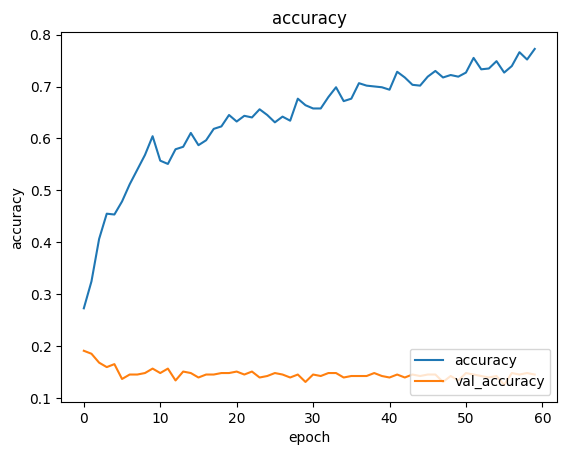

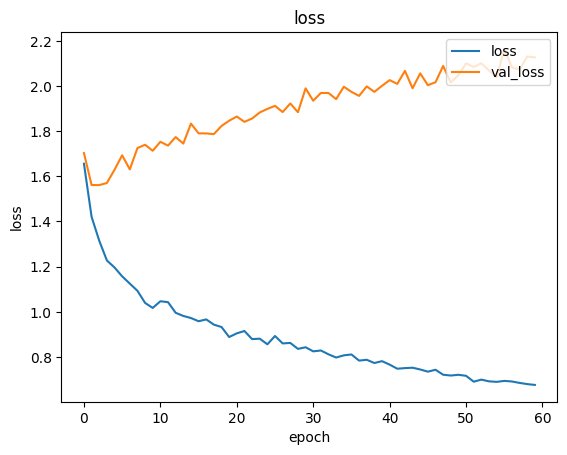

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

# 損失と精度をグラフに出力
plot_acc_loss(history)